In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

Find anomalies in the number of web pages accessed by users in the codeup curriculum.

In [2]:
# Titling columns for implementation in the dataframe

col_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']

# Creating the dataframe without times as we are going to be observing by day

df = pd.read_csv('anonymized-curriculum-access.txt',
                 sep = '\s',
                 header = None,
                 names = col_names,
                 usecols = [0, 2, 3, 4, 5])

df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
# Converting the date column to datetime, then setting it as the index

df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

# Taking a column to get the counts of accesses by day

pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

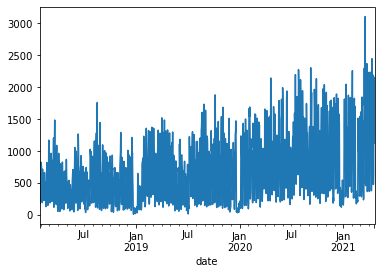

In [4]:
# Visualizing the number of accesses by day

pages.plot()

In [5]:
pages.isnull().sum()

0

## Exponential Moving Average

In [6]:
# Establishing a 7 day exponential moving average

ema_7d = pages.ewm(span = 7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [7]:
# Establishing a 14 day exponential moving average

ema_14d = pages.ewm(span = 14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [8]:
# Establishing a 30 day exponential moving average

ema_30d = pages.ewm(span = 30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

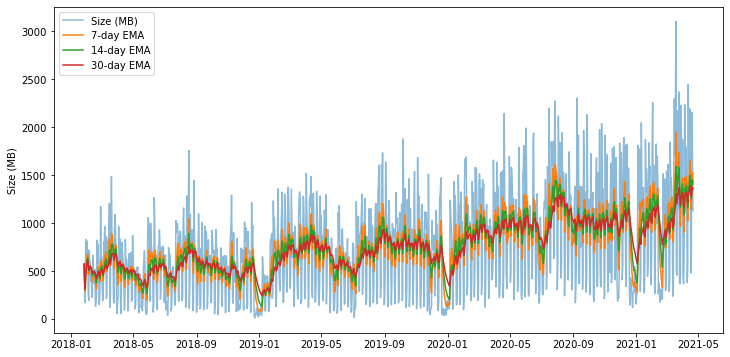

In [9]:
fig, ax = plt.subplots(figsize = (12, 6))

# Plotting the original data

ax.plot(pages.index, pages, label = 'Size (MB)', alpha =.5)

# Plotting the exponential moving averages with different spans

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')

ax.legend(loc = 'best')
ax.set_ylabel('Size (MB)')

plt.show()

## Bollinger Bands and %b

#### Bollinger Bands
- A volatility indicator commonly used in stock trading
- Has an upper band, lower band, and a midband

#### Midband
- Exponential moving average
- midband = pages.ewm(span = 30).mean()

#### Upper and Lower Bands
- UP/LB = Midband +/- stdev * K
- stdev = pages.ewm(span = 30).std()
- K = the number of standard deviations from the midpoint for upper and lower bounds

#### %b, Percent Bandwidth
- Shows where the last value sits in relation to the bands
- %b = (last - LB)/(UB - LB)
- If %b is greater than 1, this means the point lies above the upper band
- If %b is less than 0, this means the point lies below the lower band
- If %b is equal to .5, this means the point lies on the midband

#### Bandwidth
- The width of the bands
- Bandwidth = (UB - LB)/Midband

In [10]:
# Number of days to span average over

span = 30

# Calculating the midband

midband = pages.ewm(span = span).mean()
midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [11]:
# Calculating the standard deviation over a span of 30 days

stdev = pages.ewm(span = span).std()
stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [12]:
# Calculating the upper and lower bands

ub = midband + stdev*2
lb = midband - stdev*2

In [13]:
# Concatenate it together bb!

bb = pd.concat([ub, lb], axis = 1)
bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,878.961038,-88.361038
2018-01-28,742.895854,-112.616698
2018-01-29,1089.938060,-175.933288
2018-01-30,1070.328518,-67.590389


In [14]:
# Concatenating together the original data, mid, upper and lower bands

pages = pd.concat([pages, midband, bb], axis = 1)
pages.columns = ['pages', 'midband', 'ub', 'lb']
pages.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038
2018-01-28,170,315.139578,742.895854,-112.616698
2018-01-29,830,457.002386,1089.938060,-175.933288
2018-01-30,652,501.369064,1070.328518,-67.590389


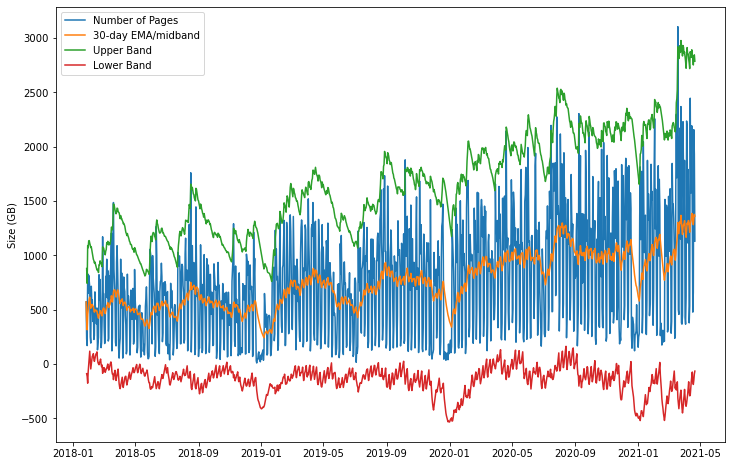

In [15]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(pages.index, pages.pages, label = 'Number of Pages')
ax.plot(pages.index, pages.midband, label = '30-day EMA/midband')
ax.plot(pages.index, pages.ub, label = 'Upper Band')
ax.plot(pages.index, pages.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (GB)')

plt.show()

Compute %b

%b = (last - LB)/(UB - LB)

Each row will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b:

In [16]:
# Getting the last measure

last_measure = pages.iloc[-1].pages
last_measure

1131.0

In [17]:
# Getting the lower band value

last_lb = pages.iloc[-1].lb
last_lb

-64.60131597531745

In [18]:
# Getting the upper band value

last_ub = pages.iloc[-1].ub
last_ub

2786.3552246649692

In [19]:
# Compute %b

last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)
print('last %b', round(last_pct_b, 2))

last %b 0.42


In [20]:
# Adding a column to calculate %b at each point in time

pages['pct_b'] = (pages['pages'] - pages['lb'])/(pages['ub'] - pages['lb'])
pages.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038,0.329116
2018-01-28,170,315.139578,742.895854,-112.616698,0.330348
2018-01-29,830,457.002386,1089.938060,-175.933288,0.794657
2018-01-30,652,501.369064,1070.328518,-67.590389,0.632374


In [21]:
# Now let's locate anomalies that reach above the upper bound, as we're not really worried about low data accesses
pages[pages['pct_b'] > 1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1171,496.375166,1077.905985,-85.155652,1.080042
2018-03-20,1486,665.021495,1472.918024,-142.875035,1.008096
2018-05-30,1056,400.137163,1018.214066,-217.939741,1.030567
2018-07-23,1027,435.495343,1010.366096,-139.375411,1.014468
2018-08-17,1760,751.910516,1655.512283,-151.691251,1.057817
2018-11-08,1291,561.449002,1248.899313,-126.001309,1.030621
2019-01-28,1232,447.643274,1168.205223,-272.918675,1.044267
2019-07-08,1225,479.213223,1215.420161,-256.993715,1.006506
2019-10-07,1879,803.738383,1792.312562,-184.835797,1.043845
